In [36]:
import numpy as np 
import pandas as pd 

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
df=pd.read_csv('Crop_recommendation.csv')
df = df.round(decimals = 2)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.88,82.00,6.50,202.94,rice
1,85,58,41,21.77,80.32,7.04,226.66,rice
2,60,55,44,23.00,82.32,7.84,263.96,rice
3,74,35,40,26.49,80.16,6.98,242.86,rice
4,78,42,42,20.13,81.60,7.63,262.72,rice


In [39]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616136,71.481877,6.469445,103.463691
std,36.917334,32.985883,50.647931,5.063700,22.263811,0.773905,54.958311
min,0.000000,5.000000,5.000000,8.830000,14.260000,3.500000,20.210000
25%,21.000000,28.000000,20.000000,22.770000,60.262500,5.970000,64.552500
50%,37.000000,51.000000,32.000000,25.600000,80.470000,6.425000,94.865000
75%,84.250000,68.000000,49.000000,28.560000,89.950000,6.920000,124.270000
max,140.000000,145.000000,205.000000,43.680000,99.980000,9.940000,298.560000


# Exploratory Data Analysis

### Heatmap to check null/missing values

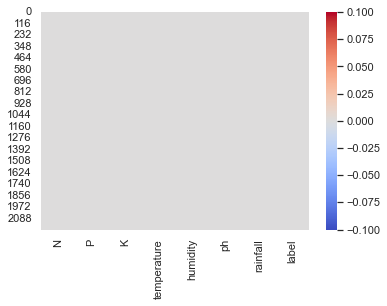

In [40]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()

<AxesSubplot:xlabel='ph', ylabel='Density'>

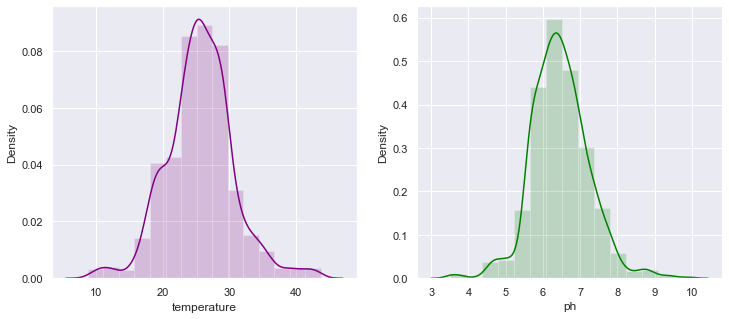

In [41]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

<AxesSubplot:xlabel='count', ylabel='label'>

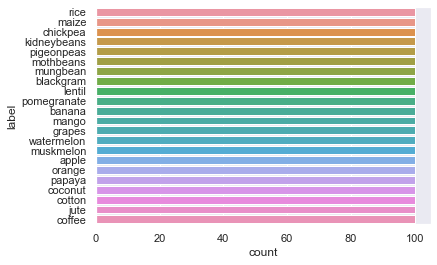

In [42]:
sns.countplot(y='label',data=df)

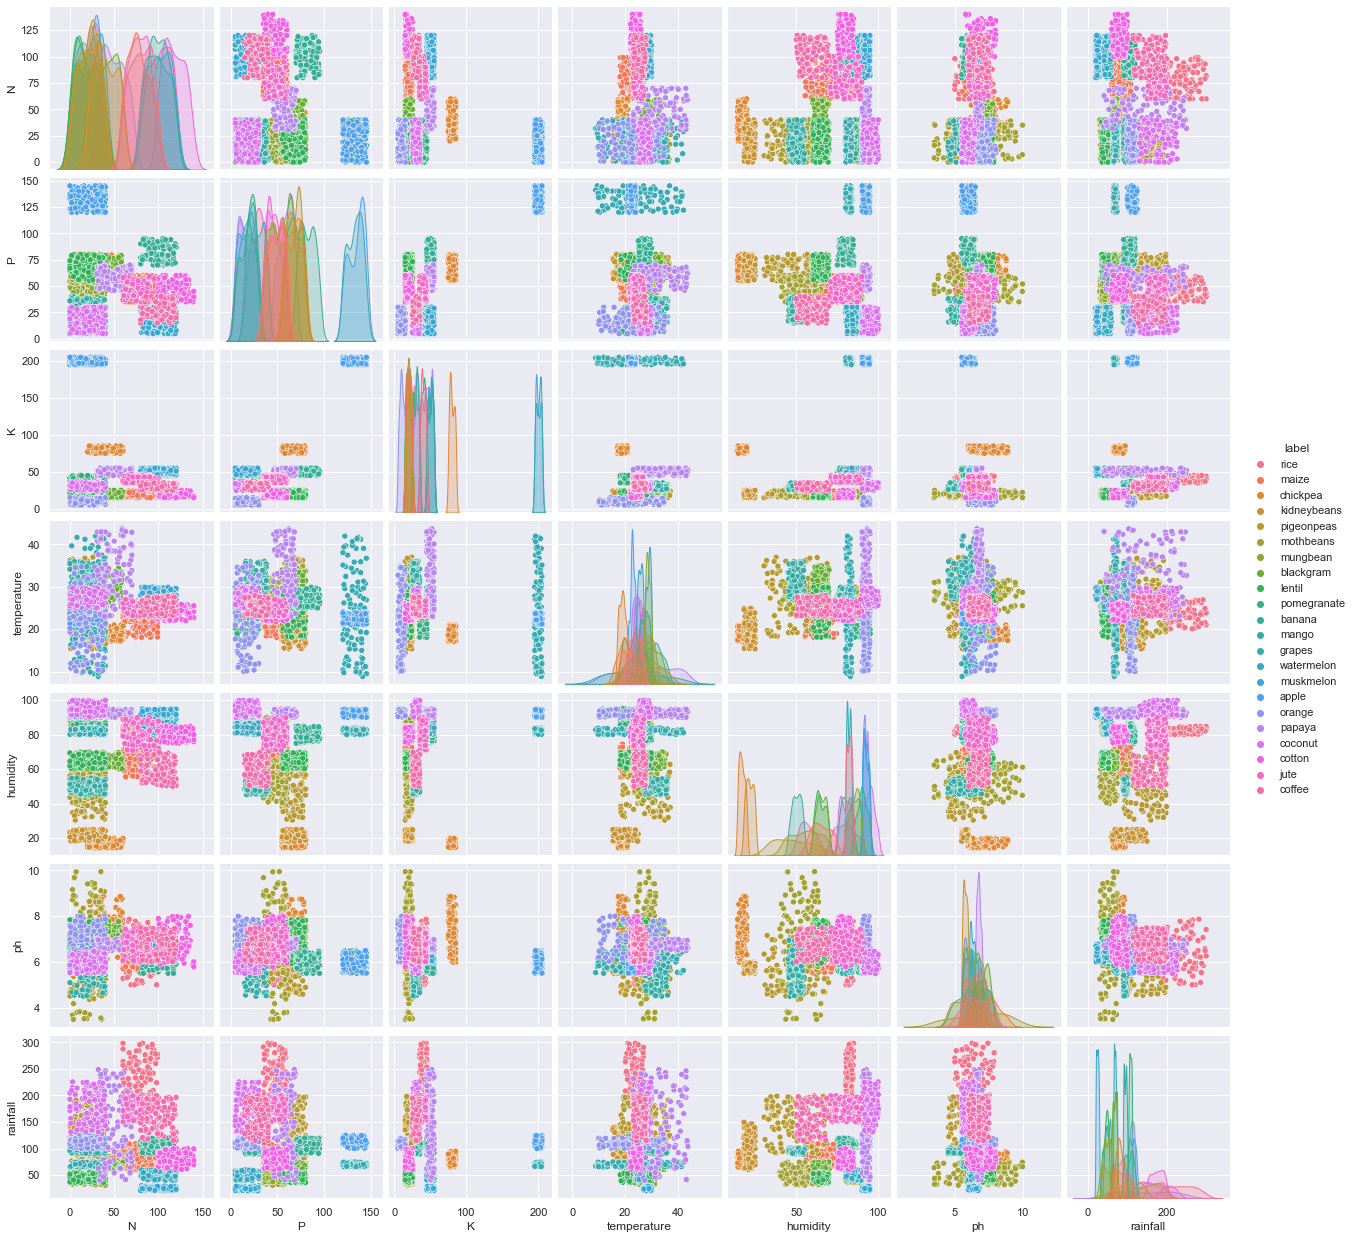

In [43]:
sns.pairplot(df, hue = 'label')

#### During rainy season, average rainfall is high (average 120 mm) and temperature is mildly chill (less than 30'C).

#### Rain affects soil moisture which affects ph of the soil. Here are the crops which are likely to be planted during this season. 

- <b> Rice needs heavy rainfall (>200 mm) and a humidity above 80%. No wonder major rice production in India comes from East Coasts which has average of 220 mm rainfall every year!
- <b> Coconut is a tropical crop and needs high humidity therefore explaining massive exports from coastal areas around the country.

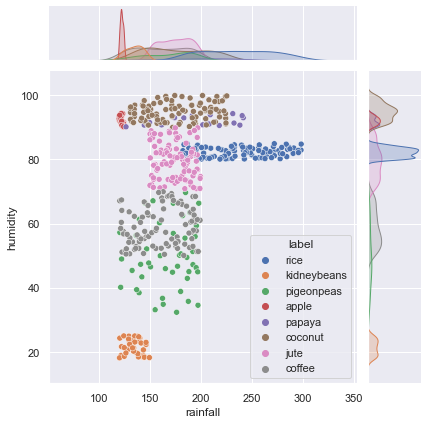

In [44]:
sns.jointplot(x="rainfall",y="humidity",data=df[(df['temperature']<30) & (df['rainfall']>120)],hue="label")

#### This graph correlates with average potassium (K) and average nitrogen (N) value (both>50). 
#### These soil ingredients direcly affects nutrition value of the food. Fruits which have high nutrients typically has consistent potassium values.

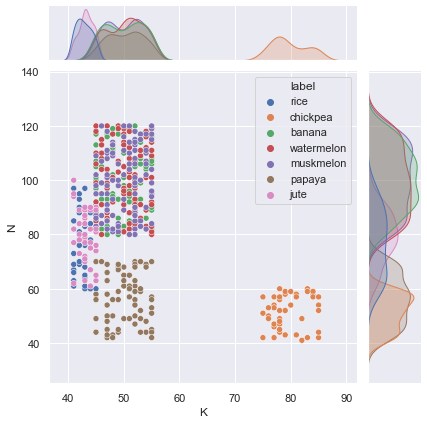

In [45]:
sns.jointplot(x="K",y="N",data=df[(df['N']>40)&(df['K']>40)],hue="label")

<h4>Let's try to plot a specfic case of pairplot between `humidity` and `K` (potassium levels in the soil.)</h4>

#### `sns.jointplot()` can be used for bivariate analysis to plot between humidity and K levels based on Label type. It further generates frequency distribution of classes with respect to features

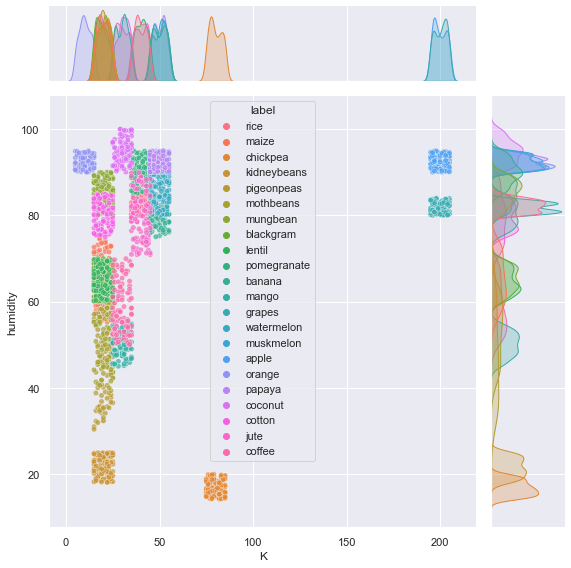

In [46]:
sns.jointplot(x="K",y="humidity",data=df,hue='label',size=8,s=30,alpha=0.7)

#### We can see ph values are critical when it comes to soil. A stability between 6 and 7 is preffered

<AxesSubplot:xlabel='ph', ylabel='label'>

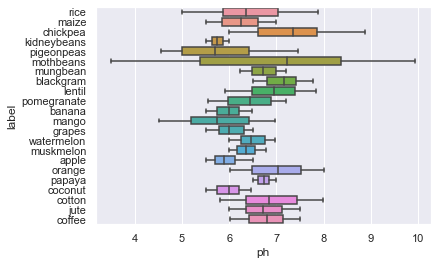

In [47]:
sns.boxplot(y='label',x='ph',data=df)

#### Another interesting analysis where Phosphorous levels are quite differentiable when it rains heavily (above 150 mm).

<AxesSubplot:xlabel='P', ylabel='label'>

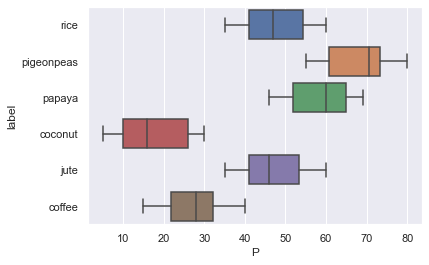

In [48]:
sns.boxplot(y='label',x='P',data=df[df['rainfall']>150])

#### Further analyzing phosphorous levels.

When humidity is less than 65, almost same phosphor levels(approx 14 to 25) are required for 6 crops which could be grown just based on the amount of rain expected over the next few weeks.

<AxesSubplot:xlabel='K', ylabel='rainfall'>

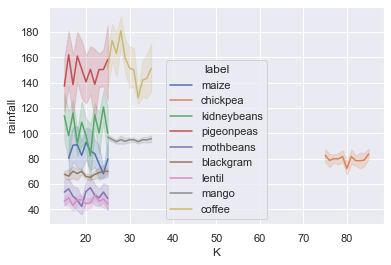

In [49]:
sns.lineplot(data = df[(df['humidity']<65)], x = "K", y = "rainfall",hue="label")

# DATA PRE-PROCESSING

### Let's make the data ready for machine learning model

In [50]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

**Correlation visualization between features. We can see how Phosphorous levels and Potassium levels are highly correlated.**

<AxesSubplot:>

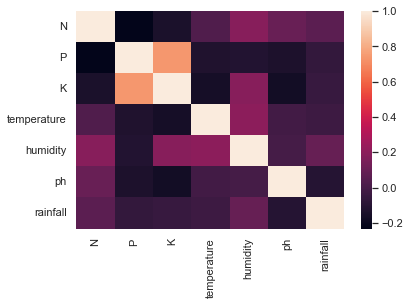

In [51]:
sns.heatmap(X.corr())

# FEATURE SCALING

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

# MODEL SELECTION

## KNN Classifier for Crop prediction. 
<hr>

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

0.9781818181818182

### Confusion Matrix

0.9781818181818182


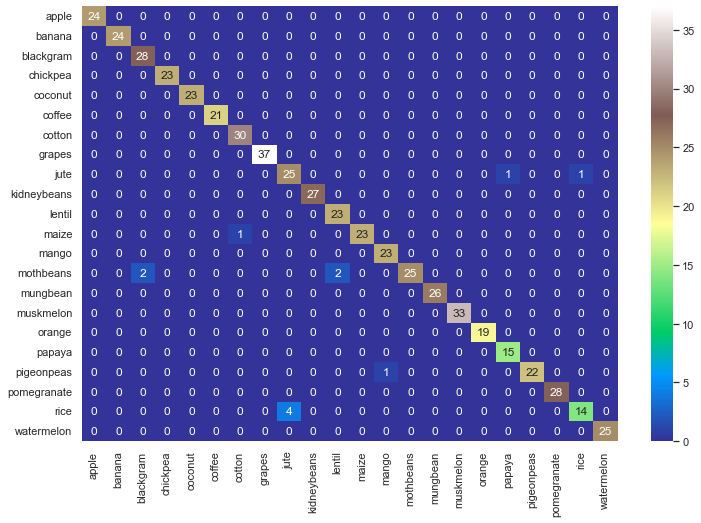

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")
print(accuracy_score(y_test,knn.predict(X_test_scaled)))

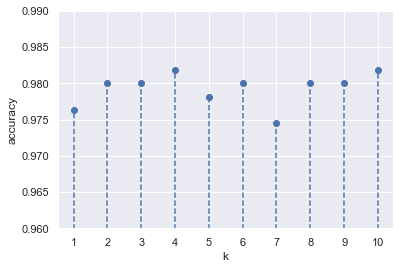

In [55]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

In [56]:
from sklearn.svm import SVC

svc_linear = SVC(kernel = 'linear').fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy: ",svc_linear.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

svc_poly = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy: ", svc_poly.score(X_test_scaled,y_test))

Linear Kernel Accuracy:  0.9745454545454545
Rbf Kernel Accuracy:  0.9872727272727273
Poly Kernel Accuracy:  0.9890909090909091


In [57]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist()}
# 'degree': np.arange(0,5,1).tolist(), 'kernel':['linear','rbf','poly']

model = GridSearchCV(estimator = SVC(kernel="linear"), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [58]:
print(model.best_score_ )
print(model.best_params_ )

0.9866710547967747
{'C': 1.0, 'gamma': 0.001}


**POINTS TO BE HIGHLIGHTED**
1. *Interestingly liner kernel also gives satisfactory results but fine tuning increases the computation and might be inefficient in some cases*
2. *The accuracy can be increased in poly kernel by tweaking parameters but might lead to intensive overfitting.*
3. *RBF has better result than linear kernel.*
4. *Poly kernel so far wins by a small margin.*

## Classifying using decision tree
<hr>

In [59]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9872727272727273

### Let's visualize the import features which are taken into consideration by decision trees.

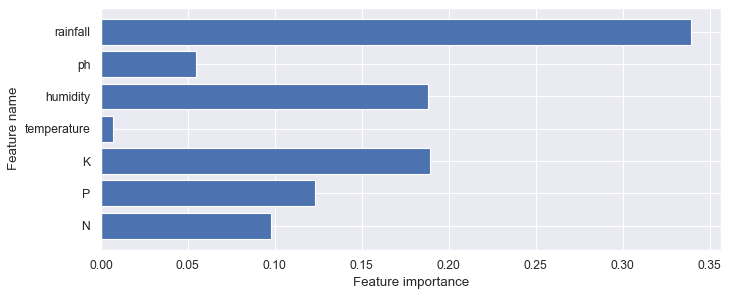

In [60]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

## Classification using Random Forest.
<hr>

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('RF Accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(accuracy_score(clf.predict(X_train), y_train))

RF Accuracy on training set: 0.97
RF Accuracy on test set: 0.97
0.9715151515151516


## Classification using Gradient Boosting
<hr>

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier().fit(X_train, y_train)
print('Gradient Boosting accuracy : {}'.format(grad.score(X_test,y_test)))

Gradient Boosting accuracy : 0.9945454545454545


In [63]:
accuracy_score(grad.predict(X_test),y_test)

0.9945454545454545

<AxesSubplot:>

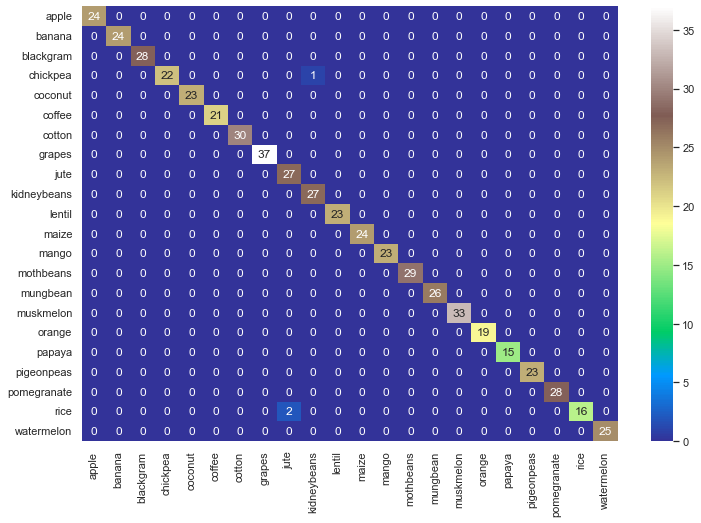

In [64]:
mat=confusion_matrix(y_test, grad.predict(X_test))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

In [65]:
X_test

,N,P,K,temperature,humidity,ph,rainfall
1276,25,129,195,17.99,81.18,5.78,72.37
1446,106,20,51,29.73,90.97,6.34,20.49
335,33,59,22,22.64,21.59,5.95,122.39
1458,89,9,47,29.47,90.77,6.67,28.75
2038,62,49,37,24.22,82.85,7.48,166.14
...,...,...,...,...,...,...,...
1987,117,43,25,24.69,78.51,7.84,69.31
592,40,55,18,30.38,40.59,7.12,47.95
470,3,60,19,25.75,40.72,4.82,100.78
1204,24,131,196,22.03,83.74,5.73,65.34


In [72]:
max(X_test.temperature)

43.04

In [66]:
import joblib
joblib.dump(grad, 'soil_details_crop_classifier.joblib.pkl')

['soil_details_crop_classifier.joblib.pkl']

In [67]:
from sklearn.metrics import classification_report
print(classification_report(grad.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        28
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        37
           8       1.00      0.93      0.96        29
           9       1.00      0.96      0.98        28
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00        33
          16       1.00      1.00      1.00        19
          17       1.00    

In [74]:
model = joblib.load('soil_details_crop_classifier.joblib.pkl')

In [75]:
model.predict(X_test)

array([ 7, 15,  9, 15,  8, 21,  9, 16,  8, 18, 19,  8,  5, 12, 13,  1,  1,
        4,  1, 16, 10,  0, 19, 17, 15,  1,  7,  4,  6, 21, 11, 11, 15,  0,
       13,  6, 12,  2, 14, 16, 18,  7, 16, 17,  4, 19, 17,  5,  3,  8,  3,
       11, 10, 19,  5, 14, 21, 21,  6, 12,  2, 14, 19,  1,  5, 15,  3,  7,
        0,  8,  7, 12, 16, 11, 20, 21, 21, 11,  6, 12,  9,  1,  0, 16,  6,
        2,  6, 12, 13, 19,  8, 18,  7, 21, 14, 14,  9,  6,  7, 14,  1,  8,
       17, 13,  4, 17, 19,  1,  6, 11, 14,  0, 19,  3, 15, 10,  2, 12, 11,
        5,  2,  8, 15,  6,  9,  3,  9, 13, 21, 14, 20, 10, 16,  0,  9,  3,
        6,  4,  3, 14, 10,  2,  5, 18, 15, 19, 17, 10, 13, 21, 14,  4, 10,
       17, 12, 14, 11,  2,  6,  8, 20,  8,  7, 17, 21, 18, 14,  0, 13,  3,
       18,  4, 18, 10,  7,  8, 20, 20,  6,  7,  6,  7,  6, 15,  2, 19,  5,
       17,  7,  1, 21, 16,  1,  0, 15, 14, 10,  7,  8, 20,  4,  2, 15, 14,
       18, 20, 11, 10,  1, 19, 21,  8,  8,  9, 15, 11,  8, 10,  5,  5, 13,
        8,  9,  6, 11, 15

In [68]:
import joblib


def page_2():
    st.title("Predict What Type of Crop is Best for your Soil")
    N = st.number_input("Nitrogen (Ratio in Soil)", min_value=0, max_value=100, value=0)
    P = st.number_input("Phosphorus (Ratio in Soil)", min_value=0, max_value=100, value=0)
    K = st.number_input("Potassium (Ratio in Soil)", min_value=0, max_value=100, value=0)
    T = st.number_input("Temperature in (Celsius)", min_value=0, max_value=45, value=0, format="%.2f")
    H = st.number_input("Humidity (%)", min_value=0, max_value=100, value=0, format="%.2f")
    ph = st.number_input("ph Level", min_value=0, max_value=10, value=0, format="%.2f")
    rainfall = st.number_input("Rainfall (in mm)", min_value=0, max_value=300, value=0, format="%.2f")
    model = joblib.load('soil_details_crop_classifier.joblib.pkl')
    
    inp = pd.DataFrame({'N': N, 'P': P, 'K': K, 'temperature': T, 'humidity': H, 'ph': ph, 'rainfall': rainfall})
    

In [73]:
X_train.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], dtype='object')